In [1]:
import numpy as np
from astropy.io import fits
import requests
from astroquery.mast import Catalogs
import zipfile
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from lightkurve import TessTargetPixelFile
%matplotlib inline
urlroot = "https://mast.stsci.edu/tesscut/api/v0.1"

In [2]:
ticid = 279540445
starName = "TIC " + str(ticid)
radSearch = 5 / 60 # radius in degrees
catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
Ra = catalogData[0]['ra']
Dec = catalogData[0]['dec']

In [3]:
# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 14
# Make it a list of Ra, Dec pairs of the bright ones. So this is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )

In [4]:
url = urlroot + "/sector"

myparams = {"ra":Ra, "dec":Dec, "radius":"0m"}

requestData = requests.get(url = url, params = myparams)

print(requestData.headers.get('content-type'))

myparams = {"ra":Ra, "dec":Dec, "x":35, "y":45, 
           "units":"px", "sector":"All"}

url = urlroot + "/astrocut"

r = requests.get(url = url, params = myparams)

print(r)
print(r.headers.get('content-type'))

application/json; charset=UTF-8
<Response [200]>
application/zip


In [5]:
sectors = requestData.json()['results']

In [6]:
open('astrocut.zip', 'wb').write(r.content)
zipRef = zipfile.ZipFile('astrocut.zip','r')
zipRef.extractall('.')
zipRef.close()
# Get list of cuotut names
cutoutnames = zipRef.namelist()
file1 = cutoutnames[0]
hdu1 = fits.open(file1)

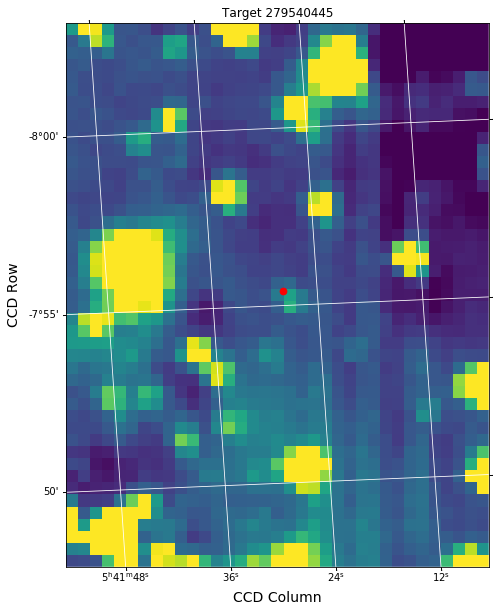

In [7]:
firstImage = hdu1[1].data['FLUX'][0]
wcs = WCS(hdu1[2].header)
fig = plt.figure(figsize = (10,10))
fig.add_subplot(111, projection = wcs)
plt.imshow(firstImage, origin = 'lower', cmap = plt.cm.viridis, vmax = np.percentile(firstImage,92),\
           vmin = np.percentile(firstImage,5))
plt.xlabel('CCD Column', fontsize = 14)
plt.ylabel('CCD Row', fontsize = 14)
plt.grid(axis = 'both', color = 'white', ls = 'solid')
starLoc = wcs.all_world2pix([[Ra,Dec]],0)  #Second is origin
plt.scatter(starLoc[0,0], starLoc[0,1], s = 45, color = 'red')
# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:], 0)
plt.scatter(nearbyLoc[1:,0], nearbyLoc[1:,1], s = 25, color = 'orange')
plt.title("Target "+ str(ticid))
plt.show()

In [9]:
tpf=TessTargetPixelFile("https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=85.389091&dec=-7.998965&y=15&x=15&units=px&sector=6")

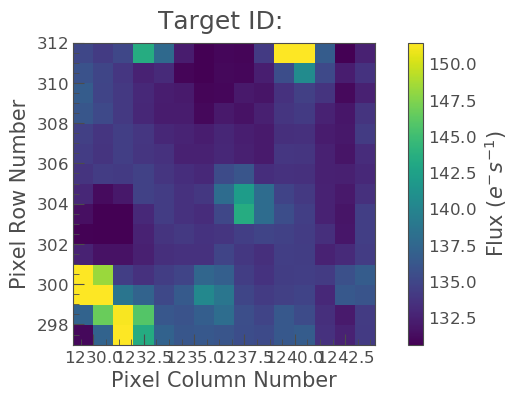

In [10]:
tpf.plot()

In [13]:
tpf_zoom=TessTargetPixelFile("https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=85.389091&dec=-7.998965&y=7&x=7&units=px&sector=6")

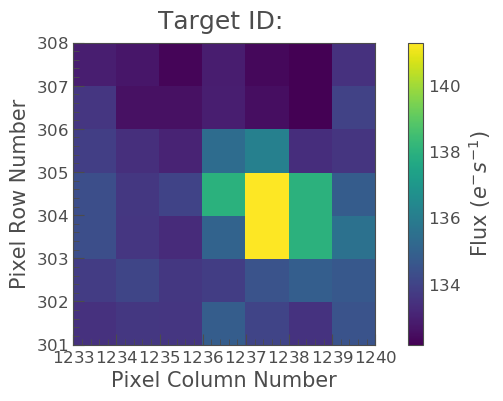

In [14]:
tpf_zoom.plot()

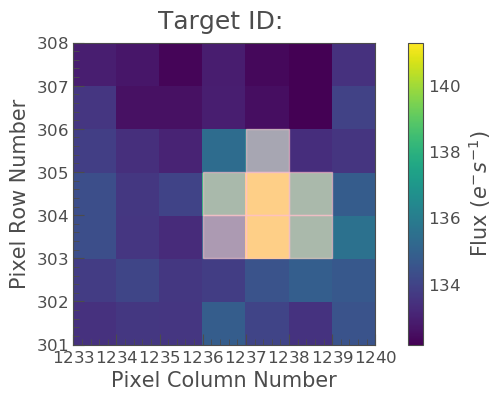

In [16]:
#This code is used to create a new aperture. Please note that this code is from Lightkurve Tutorials. 
import numpy as np
# Create a median image of the source over time
median_image = np.nanmedian(tpf_zoom.flux, axis=0)
# Select pixels which are brighter than the 86th percentile of th median image
aperture_mask = median_image > np.nanpercentile(median_image,86)
# Plot that aperture
tpf_zoom.plot(aperture_mask=aperture_mask);

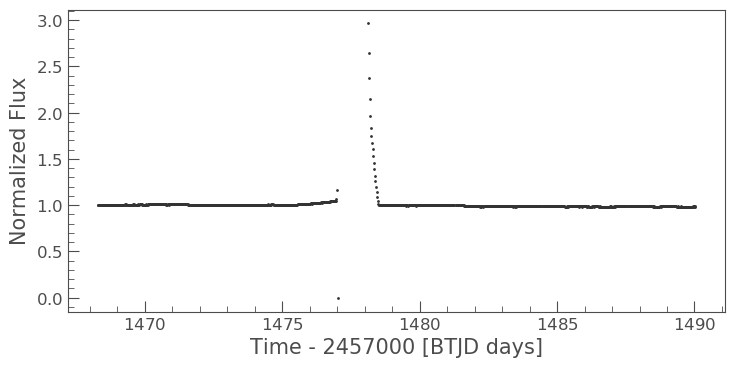

In [17]:
lc=tpf_zoom.to_lightcurve(aperture_mask=aperture_mask)
lc.scatter()

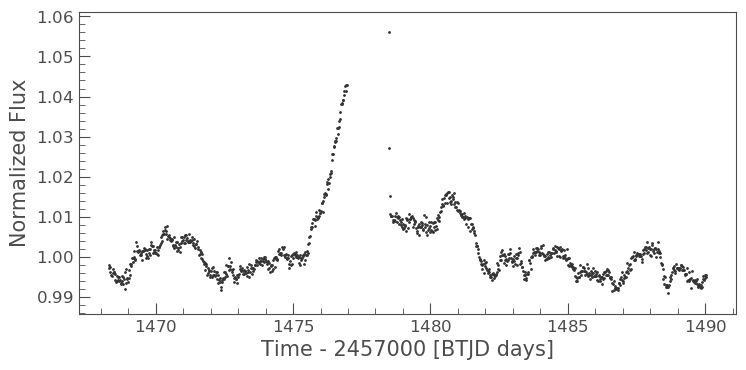

In [20]:
lc.remove_nans().remove_outliers(sigma=5).flatten(1475).scatter()